# ann-project

5조
한수호, 강구현, 김민규, 홍준기

# Setup

In [1]:
from models.simple_cnn import CNNModel
from models.residual import ResModel
from models.resnet50 import ResNetModel
from models.lenet import LeNetModel
from keras import callbacks, optimizers, layers
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import seaborn as sns
import pickle
import random
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

2024-05-28 19:43:00.014099: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 19:43:00.014138: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 19:43:00.014175: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-28 19:43:00.021524: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 19:43:00.768006: W tensorflow/compiler/

In [2]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

In [3]:
from datetime import datetime
result_path = './results'
_time = datetime.strftime(datetime.today(), '%Y-%m-%d_%H-%M-%S')

dataset

In [4]:
train_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-byclass-train.csv'
test_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-byclass-test.csv'

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Data dimensions and sizes
num_train_samples = train_data.shape[0]
num_test_samples = test_data.shape[0]

# Prepare data
x_train = train_data.iloc[:, 1:].to_numpy().reshape((num_train_samples, 28, 28, 1))
x_test = test_data.iloc[:, 1:].to_numpy().reshape((num_test_samples, 28, 28, 1))
y_train = tf.keras.utils.to_categorical(train_data.iloc[:, 0], 62)  # 62 classes for EMNIST ByClass
y_test = tf.keras.utils.to_categorical(test_data.iloc[:, 0], 62)

# Integer labels for sparse categorical crossentropy
y_train_int = train_data.iloc[:, 0].to_numpy()
y_test_int = test_data.iloc[:, 0].to_numpy()

# Split the training data into training and validation sets
_, _, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
x_train, x_valid, y_train_int, y_valid_int = train_test_split(x_train, y_train_int, test_size=0.1, random_state=42)

# Prepare data for ResNet
x_train_resized = tf.image.resize(x_train, [32, 32])
x_valid_resized = tf.image.resize(x_valid, [32, 32])
x_test_resized = tf.image.resize(x_test, [32, 32])

Loading training data: 0it [00:00, ?it/s]

Loading test data: 0it [00:00, ?it/s]

2024-05-28 19:43:27.350796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-28 19:43:27.379135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-28 19:43:27.379423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

checkpoints

In [35]:
def create_callbacks(model_name):
    current_time = int(time.time())
    checkpoint_path = f"./checkpoints/checkpoints_{model_name}/weights.{current_time}.hdf5"

    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001)
    checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

    return [reduce_lr, checkpoint]


callbacks_lenet = create_callbacks('lenet')
callbacks_resnet = create_callbacks('resnet')
callbacks_ours_1 = create_callbacks('ours_1')
callbacks_ours_2 = create_callbacks('ours_2')
callbacks_final = create_callbacks('final')
result_path = './results'

test results

In [6]:
def save_results(results_df):
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    results_df.to_csv(os.path.join(result_path, f'result_{_time}.csv'), index=False)

saving history

In [29]:
def save_history(histories, filename):
    with open(os.path.join(result_path, filename), 'w') as f:
        json.dump(histories, f)

# 1. baseline과 our 모델 비교

In [8]:
# Initialize models
lenet_model = LeNetModel()
resnet_model = ResNetModel()
our_model_1 = CNNModel()
our_model_2res = ResModel()

# Compile models
lenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_2res.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
history = []
training_time = []

In [10]:
EPOCHS = 30
BATCH_SIZE = 500

In [11]:
start_time = time.time()
history.append(lenet_model.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_lenet]))
end_time = time.time()
training_time.append(end_time-start_time)

2024-05-28 19:43:50.320451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2024-05-28 19:43:51.142246: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x76d4404b2de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-28 19:43:51.142273: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-05-28 19:43:51.146260: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-28 19:43:51.227651: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1257/1257 [==============================] - ETA: 0s - loss: 0.6575 - accuracy: 0.7954
Epoch 1: val_loss improved from inf to 0.46609, saving model to ./checkpoints/checkpoints_lenet/weights.1716893020.hdf5
1257/1257 [==============================] - 9s 4ms/step - loss: 0.6575 - accuracy: 0.7954 - val_loss: 0.4661 - val_accuracy: 0.8376 - lr: 0.0010


/home/suhohan/anaconda3/envs/ann/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
start_time = time.time()
history.append(resnet_model.train(x_train_resized, y_train_int, validation_data=(x_valid_resized,
               y_valid_int), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_resnet]))
end_time = time.time()
training_time.append(end_time-start_time)

1257/1257 [==============================] - ETA: 0s - loss: 0.5850 - accuracy: 0.8126
Epoch 1: val_loss improved from inf to 0.44833, saving model to ./checkpoints/checkpoints_resnet/weights.1716893020.hdf5
1257/1257 [==============================] - 79s 45ms/step - loss: 0.5850 - accuracy: 0.8126 - val_loss: 0.4483 - val_accuracy: 0.8423 - lr: 0.0010


In [13]:
start_time = time.time()
history.append(our_model_1.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_ours_1]))
end_time = time.time()
training_time.append(end_time-start_time)

1257/1257 [==============================] - ETA: 0s - loss: 0.8528 - accuracy: 0.7618
Epoch 1: val_loss improved from inf to 0.48063, saving model to ./checkpoints/checkpoints_ours_1/weights.1716893020.hdf5
1257/1257 [==============================] - 8s 5ms/step - loss: 0.8528 - accuracy: 0.7618 - val_loss: 0.4806 - val_accuracy: 0.8326 - lr: 0.0010


In [14]:
start_time = time.time()
history.append(our_model_2res.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_ours_2]))
end_time = time.time()
training_time.append(end_time-start_time)

2024-05-28 19:45:39.480509: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 0.5708 - accuracy: 0.8126
Epoch 1: val_loss improved from inf to 0.40792, saving model to ./checkpoints/checkpoints_ours_2/weights.1716893020.hdf5
1257/1257 [==============================] - 32s 21ms/step - loss: 0.5708 - accuracy: 0.8126 - val_loss: 0.4079 - val_accuracy: 0.8505 - lr: 0.0010


In [15]:
loss_lenet, acc_lenet = lenet_model.evaluate(x_test, y_test_int)
loss_resnet, acc_resnet = resnet_model.evaluate(x_test_resized, y_test_int)
loss_our1, acc_our1 = our_model_1.evaluate(x_test, y_test_int)
loss_our2, acc_our2 = our_model_2res.evaluate(x_test, y_test_int)

3636/3636 [==============================] - 9s 2ms/step - loss: 0.3995 - accuracy: 0.8518


In [39]:
results = {
    "Model": ["LeNet-5", "ResNet-50", "Our Model(CNN)", "Our Model(Residual)"],
    "Loss": [loss_lenet, loss_resnet, loss_our1, loss_our2],
    "Accuracy": [acc_lenet, acc_resnet, acc_our1, acc_our2],
    "Training Time": training_time
}
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_{_time}.csv', index=False)

In [41]:
models = ["lenet-5", "resnet-50", "our_model_cnn", "our_model_residual"]
for model_name, h in zip(models, history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}  # Ensure values are float
    save_history(history_dict, f'history_{model_name}.json')

In [ ]:
colors = ["red", "blue", "green", "purple", "gold"]

plt.figure(figsize=(10, 5))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_{_time}.png")
plt.show()
save_history(history, 'history_activation.pkl')

In [ ]:
training_time.append("")
results = {
    "Model": ["LeNet-5", "ResNet-50", "Our Model", "Wavemix-256[6]"],
    "Loss": [loss_lenet, loss_resnet, loss_our1, loss_our2, 0],
    "Accuracy": [acc_lenet, acc_resnet, acc_our1, acc_our2, 0.8842],
    "Training Time": training_time
}
results_df = pd.DataFrame(results)

In [ ]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(5, 6))
    sns.barplot(x="Model", y=metric, hue="Model", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_{_time}.png')
    plt.show()

# 2. Experiment

## 2.1. Optimizer

In [42]:
optimizers_list = [
    optimizers.SGD(learning_rate=0.001, momentum=0.9),
    optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    optimizers.Adagrad(learning_rate=0.001),
    optimizers.RMSprop(learning_rate=0.001, rho=0.9),
    optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
]

In [43]:
history = []
results = {'Optimizer': [], 'Loss': [], 'Accuracy': [], 'Training Time': []}

In [44]:
def _train_opt(x_train, y_train, validation_data, optimizer, activation_ftn='ReLU'):
    print(f"Start with {type(optimizer).__name__}")
    final_model = ResModel(num_classes=62, initial_filters=32,
                           dropout_rate=0.3, final_dropout_rate=0.6, activation=activation_ftn, num_residual_units=3)
    optimizer.build(final_model.model.trainable_variables)

    final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = final_model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                             batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = final_model.evaluate(x_test, y_test_int)
    results['Optimizer'].append(type(optimizer).__name__)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

    print(f"End with {type(optimizer).__name__}")

In [45]:
EPOCHS = 10
BATCH_SIZE = 500

In [46]:
for optimizer in optimizers_list:
    _train_opt(x_train, y_train_int, (x_valid, y_valid_int), optimizer, activation_ftn='ReLU')

Start with SGD
Epoch 1/10


2024-05-28 20:02:06.975019: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 1.6047 - accuracy: 0.5895
Epoch 1: val_loss improved from inf to 0.68167, saving model to ./checkpoints/checkpoints_final/weights.1716893935.hdf5
1257/1257 [==============================] - 27s 20ms/step - loss: 1.6040 - accuracy: 0.5896 - val_loss: 0.6817 - val_accuracy: 0.7847 - lr: 0.0010
Epoch 2/10
   4/1257 [..............................] - ETA: 22s - loss: 0.9559 - accuracy: 0.7230

/home/suhohan/anaconda3/envs/ann/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1255/1257 [============================>.] - ETA: 0s - loss: 0.8103 - accuracy: 0.7525
Epoch 2: val_loss improved from 0.68167 to 0.51949, saving model to ./checkpoints/checkpoints_final/weights.1716893935.hdf5
1257/1257 [==============================] - 24s 19ms/step - loss: 0.8102 - accuracy: 0.7525 - val_loss: 0.5195 - val_accuracy: 0.8245 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.7870
Epoch 3: val_loss improved from 0.51949 to 0.47204, saving model to ./checkpoints/checkpoints_final/weights.1716893935.hdf5
1257/1257 [==============================] - 25s 20ms/step - loss: 0.6621 - accuracy: 0.7870 - val_loss: 0.4720 - val_accuracy: 0.8367 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.5932 - accuracy: 0.8046
Epoch 4: val_loss improved from 0.47204 to 0.44404, saving model to ./checkpoints/checkpoints_final/weights.1716893935.hdf5
1257/1257 [==============================] - 24s 

2024-05-28 20:06:31.595844: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 1.5780 - accuracy: 0.5940
Epoch 1: val_loss did not improve from 0.39288
1257/1257 [==============================] - 28s 21ms/step - loss: 1.5773 - accuracy: 0.5942 - val_loss: 0.6857 - val_accuracy: 0.7809 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.8054 - accuracy: 0.7525
Epoch 2: val_loss did not improve from 0.39288
1257/1257 [==============================] - 24s 19ms/step - loss: 0.8053 - accuracy: 0.7526 - val_loss: 0.5184 - val_accuracy: 0.8248 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.6622 - accuracy: 0.7866
Epoch 3: val_loss did not improve from 0.39288
1257/1257 [==============================] - 24s 19ms/step - loss: 0.6623 - accuracy: 0.7866 - val_loss: 0.4804 - val_accuracy: 0.8341 - lr: 0.0010
Epoch 4/10
1257/1257 [==============================] - ETA: 0s - loss: 0.5937 - accuracy: 0.8041
Epoch 4: val_loss did not improve 

2024-05-28 20:10:55.906234: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 2.3975 - accuracy: 0.4280
Epoch 1: val_loss did not improve from 0.39288
1257/1257 [==============================] - 28s 20ms/step - loss: 2.3967 - accuracy: 0.4282 - val_loss: 1.1650 - val_accuracy: 0.6838 - lr: 0.0010
Epoch 2/10
1254/1257 [============================>.] - ETA: 0s - loss: 1.3899 - accuracy: 0.6271
Epoch 2: val_loss did not improve from 0.39288
1257/1257 [==============================] - 25s 20ms/step - loss: 1.3896 - accuracy: 0.6272 - val_loss: 0.8513 - val_accuracy: 0.7439 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 1.1071 - accuracy: 0.6845
Epoch 3: val_loss did not improve from 0.39288
1257/1257 [==============================] - 24s 19ms/step - loss: 1.1072 - accuracy: 0.6844 - val_loss: 0.7098 - val_accuracy: 0.7772 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.9569 - accuracy: 0.7176
Epoch 4: val_loss did not improve 

2024-05-28 20:15:21.429512: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.5522 - accuracy: 0.8156
Epoch 1: val_loss did not improve from 0.39288
1257/1257 [==============================] - 28s 20ms/step - loss: 0.5521 - accuracy: 0.8156 - val_loss: 0.3985 - val_accuracy: 0.8551 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3999 - accuracy: 0.8557
Epoch 2: val_loss did not improve from 0.39288
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4000 - accuracy: 0.8557 - val_loss: 0.3993 - val_accuracy: 0.8580 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3794 - accuracy: 0.8618
Epoch 3: val_loss did not improve from 0.39288
1257/1257 [==============================] - 25s 20ms/step - loss: 0.3795 - accuracy: 0.8617 - val_loss: 0.3972 - val_accuracy: 0.8552 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3675 - accuracy: 0.8651
Epoch 4: val_loss improved from 0.

2024-05-28 20:19:55.263116: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_25/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.5767 - accuracy: 0.8105
Epoch 1: val_loss did not improve from 0.33822
1257/1257 [==============================] - 30s 20ms/step - loss: 0.5766 - accuracy: 0.8105 - val_loss: 0.3829 - val_accuracy: 0.8585 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4029 - accuracy: 0.8542
Epoch 2: val_loss did not improve from 0.33822
1257/1257 [==============================] - 26s 20ms/step - loss: 0.4029 - accuracy: 0.8542 - val_loss: 0.3623 - val_accuracy: 0.8664 - lr: 0.0010
Epoch 3/10
1254/1257 [============================>.] - ETA: 0s - loss: 0.3801 - accuracy: 0.8607
Epoch 3: val_loss did not improve from 0.33822
1257/1257 [==============================] - 25s 20ms/step - loss: 0.3802 - accuracy: 0.8607 - val_loss: 0.3543 - val_accuracy: 0.8688 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3668 - accuracy: 0.8645
Epoch 4: val_loss did not improve 

2024-05-28 20:24:28.699219: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 0.6892 - accuracy: 0.7854
Epoch 1: val_loss did not improve from 0.33091
1257/1257 [==============================] - 30s 21ms/step - loss: 0.6892 - accuracy: 0.7854 - val_loss: 0.4095 - val_accuracy: 0.8504 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4322 - accuracy: 0.8470
Epoch 2: val_loss did not improve from 0.33091
1257/1257 [==============================] - 25s 20ms/step - loss: 0.4322 - accuracy: 0.8470 - val_loss: 0.3780 - val_accuracy: 0.8616 - lr: 0.0010
Epoch 3/10
1254/1257 [============================>.] - ETA: 0s - loss: 0.3933 - accuracy: 0.8576
Epoch 3: val_loss did not improve from 0.33091
1257/1257 [==============================] - 25s 20ms/step - loss: 0.3933 - accuracy: 0.8576 - val_loss: 0.3640 - val_accuracy: 0.8668 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3748 - accuracy: 0.8628
Epoch 4: val_loss did not improve 

2024-05-28 20:29:03.292792: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/dropout_35/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1256/1257 [============================>.] - ETA: 0s - loss: 0.5720 - accuracy: 0.8125
Epoch 1: val_loss did not improve from 0.32842
1257/1257 [==============================] - 39s 24ms/step - loss: 0.5720 - accuracy: 0.8125 - val_loss: 0.4033 - val_accuracy: 0.8513 - lr: 0.0010
Epoch 2/10
1256/1257 [============================>.] - ETA: 0s - loss: 0.4006 - accuracy: 0.8550
Epoch 2: val_loss did not improve from 0.32842
1257/1257 [==============================] - 28s 22ms/step - loss: 0.4006 - accuracy: 0.8550 - val_loss: 0.3632 - val_accuracy: 0.8655 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3789 - accuracy: 0.8612
Epoch 3: val_loss did not improve from 0.32842
1257/1257 [==============================] - 30s 24ms/step - loss: 0.3789 - accuracy: 0.8612 - val_loss: 0.3564 - val_accuracy: 0.8679 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3658 - accuracy: 0.8649
Epoch 4: val_loss did not improve 

In [49]:
results_df = pd.DataFrame(results)
save_results(results_df)
for optimizer, h in zip(optimizers_list, history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}  # Ensure values are float
    save_history(history_dict, f'history_optimizer_{type(optimizer).__name__}.json')

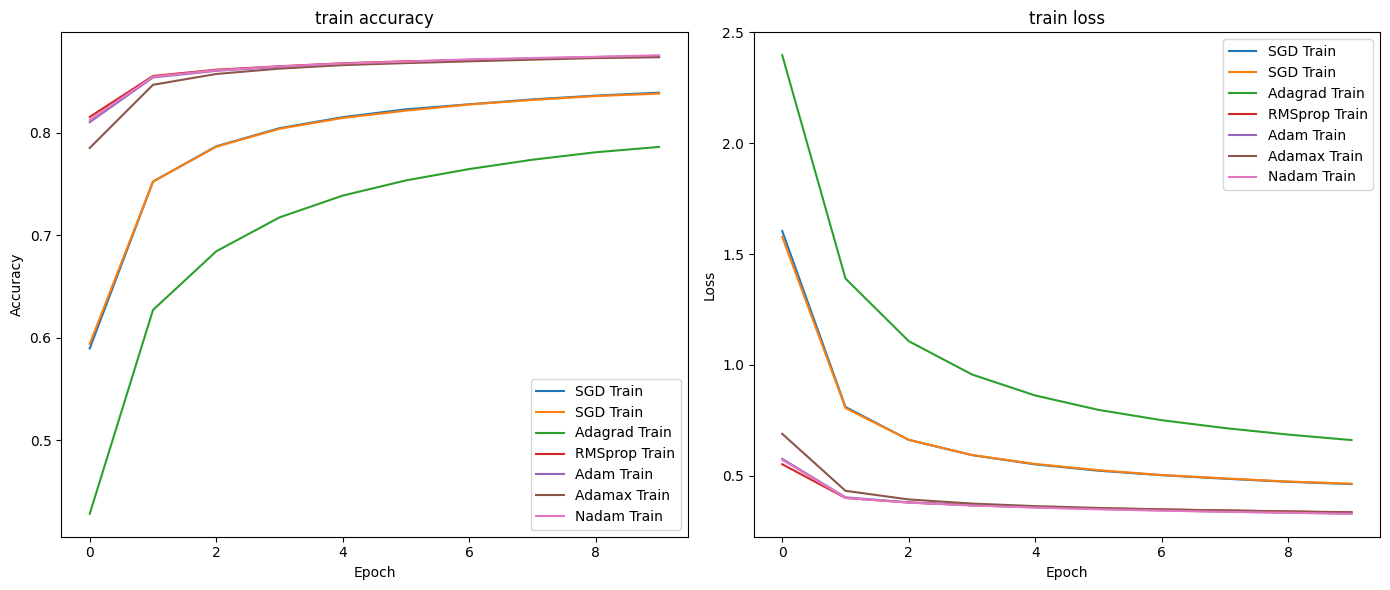

In [50]:
plt.figure(figsize=(14, 6))

for i, h in enumerate(history):
    plt.subplot(1, 2, 1)
    plt.plot(h.history['accuracy'], label=f'{type(optimizers_list[i]).__name__} Train')
    plt.title('train accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(h.history['loss'], label=f'{type(optimizers_list[i]).__name__} Train')
    plt.title('train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

plt.tight_layout()
plt.savefig(f"{result_path}/result_{_time}.png")
plt.show()

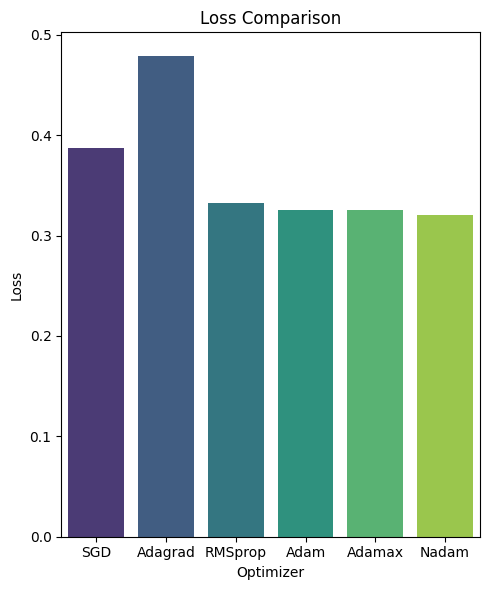

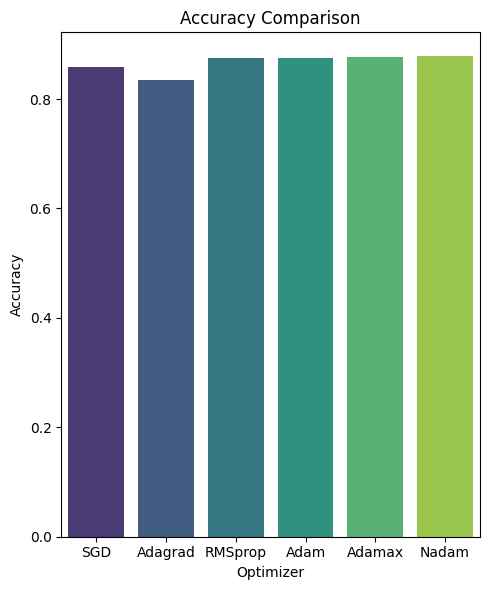

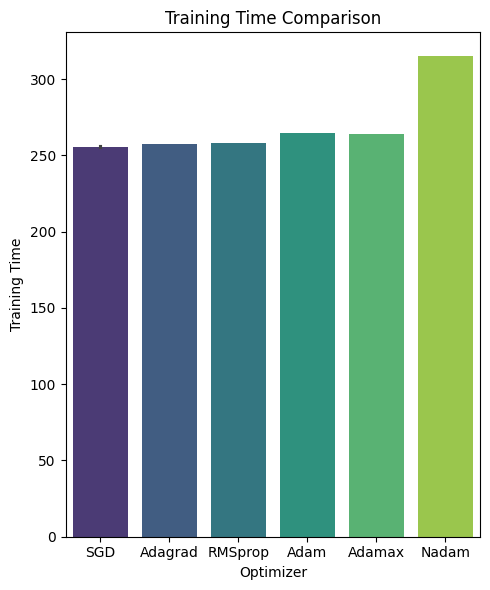

In [51]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(5, 6))
    sns.barplot(x="Optimizer", y=metric, hue="Optimizer", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Optimizer')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_{_time}.png')
    plt.show()

## 2.2. Activation Function

In [52]:
activations = {
    'relu': layers.ReLU(),
    'leaky_relu': layers.LeakyReLU(),
    'elu': layers.ELU(),
    'selu': layers.Activation('selu'),
    'sigmoid': layers.Activation('sigmoid'),
    'tanh': layers.Activation('tanh'),
    'softmax': layers.Activation('softmax'),
    'softplus': layers.Activation('softplus'),
    'softsign': layers.Activation('softsign'),
    'swish': layers.Activation('swish'),
    'gelu': layers.Activation('gelu')
}

In [53]:
history = []
results = {'Activation Function': [], 'Loss': [], 'Accuracy': [], 'Training Time': []}

In [54]:
best_optimizer = optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
activation_functions = ['relu', 'leaky_relu', 'elu', 'selu', 'sigmoid', 'tanh',
                        'softmax', 'softplus', 'softsign', 'swish', 'gelu']

In [55]:
def _train_act(x_train, y_train, validation_data, optimizer, activation_ftn):
    print(f"Start with {activation_ftn}")

    activation_layer = activations.get(activation_ftn, layers.ReLU())

    final_model = ResModel(num_classes=62, initial_filters=32, dropout_rate=0.3,
                           final_dropout_rate=0.6, activation=activation_layer, num_residual_units=3)
    final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = final_model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                             batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = final_model.evaluate(x_test, y_test_int)
    results['Activation Function'].append(activation_ftn)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

    print(f"End with {activation_ftn}")

In [56]:
EPOCHS = 10
BATCH_SIZE = 500

In [57]:
for ftn in activation_functions:
    _train_act(x_train, y_train_int, (x_valid, y_valid_int), optimizer=best_optimizer, activation_ftn=ftn)

Start with relu
Epoch 1/10


2024-05-28 20:46:04.870362: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/dropout_40/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.5729 - accuracy: 0.8118
Epoch 1: val_loss did not improve from 0.32642
1257/1257 [==============================] - 25s 19ms/step - loss: 0.5727 - accuracy: 0.8118 - val_loss: 0.3868 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4016 - accuracy: 0.8549
Epoch 2: val_loss did not improve from 0.32642
1257/1257 [==============================] - 23s 19ms/step - loss: 0.4016 - accuracy: 0.8549 - val_loss: 0.3641 - val_accuracy: 0.8640 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3802 - accuracy: 0.8606
Epoch 3: val_loss did not improve from 0.32642
1257/1257 [==============================] - 24s 19ms/step - loss: 0.3802 - accuracy: 0.8606 - val_loss: 0.3591 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3667 - accuracy: 0.8644
Epoch 4: val_loss did not improve 

2024-05-28 20:50:15.472092: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/dropout_45/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.5579 - accuracy: 0.8120
Epoch 1: val_loss did not improve from 0.32642
1257/1257 [==============================] - 25s 19ms/step - loss: 0.5578 - accuracy: 0.8120 - val_loss: 0.4077 - val_accuracy: 0.8524 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4243 - accuracy: 0.8476
Epoch 2: val_loss did not improve from 0.32642
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4244 - accuracy: 0.8476 - val_loss: 0.3802 - val_accuracy: 0.8619 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4018 - accuracy: 0.8542
Epoch 3: val_loss did not improve from 0.32642
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4018 - accuracy: 0.8542 - val_loss: 0.3732 - val_accuracy: 0.8631 - lr: 0.0010
Epoch 4/10
1254/1257 [============================>.] - ETA: 0s - loss: 0.3891 - accuracy: 0.8578
Epoch 4: val_loss did not improve 

2024-05-28 20:54:29.035971: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_11/dropout_50/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.5906 - accuracy: 0.8033
Epoch 1: val_loss did not improve from 0.32642
1257/1257 [==============================] - 25s 19ms/step - loss: 0.5905 - accuracy: 0.8033 - val_loss: 0.4079 - val_accuracy: 0.8535 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4303 - accuracy: 0.8460
Epoch 2: val_loss did not improve from 0.32642
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4303 - accuracy: 0.8460 - val_loss: 0.3854 - val_accuracy: 0.8599 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4043 - accuracy: 0.8537
Epoch 3: val_loss did not improve from 0.32642
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4043 - accuracy: 0.8537 - val_loss: 0.3771 - val_accuracy: 0.8628 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3894 - accuracy: 0.8576
Epoch 4: val_loss did not improve 

2024-05-28 20:58:49.448578: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_12/dropout_55/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.6373 - accuracy: 0.7929
Epoch 1: val_loss did not improve from 0.32642
1257/1257 [==============================] - 25s 19ms/step - loss: 0.6372 - accuracy: 0.7929 - val_loss: 0.4460 - val_accuracy: 0.8406 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4498 - accuracy: 0.8409
Epoch 2: val_loss did not improve from 0.32642
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4498 - accuracy: 0.8409 - val_loss: 0.4004 - val_accuracy: 0.8560 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4196 - accuracy: 0.8492
Epoch 3: val_loss did not improve from 0.32642
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4196 - accuracy: 0.8492 - val_loss: 0.3851 - val_accuracy: 0.8602 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4033 - accuracy: 0.8539
Epoch 4: val_loss did not improve 

2024-05-28 21:03:03.997782: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_13/dropout_60/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.8308 - accuracy: 0.7431
Epoch 1: val_loss did not improve from 0.32642
1257/1257 [==============================] - 25s 19ms/step - loss: 0.8305 - accuracy: 0.7432 - val_loss: 0.4956 - val_accuracy: 0.8233 - lr: 0.0010
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4821 - accuracy: 0.8321
Epoch 2: val_loss did not improve from 0.32642
1257/1257 [==============================] - 23s 19ms/step - loss: 0.4821 - accuracy: 0.8321 - val_loss: 0.4524 - val_accuracy: 0.8391 - lr: 0.0010
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4402 - accuracy: 0.8443
Epoch 3: val_loss did not improve from 0.32642
1257/1257 [==============================] - 23s 19ms/step - loss: 0.4402 - accuracy: 0.8443 - val_loss: 0.6361 - val_accuracy: 0.7829 - lr: 0.0010
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4192 - accuracy: 0.8498
Epoch 4: val_loss did not improve 

2024-05-28 21:07:18.029181: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_14/dropout_65/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1254/1257 [============================>.] - ETA: 0s - loss: 0.5829 - accuracy: 0.8064
Epoch 1: val_loss did not improve from 0.32642
1257/1257 [==============================] - 25s 19ms/step - loss: 0.5827 - accuracy: 0.8065 - val_loss: 0.4087 - val_accuracy: 0.8527 - lr: 5.0000e-04
Epoch 2/10
1254/1257 [============================>.] - ETA: 0s - loss: 0.4358 - accuracy: 0.8453
Epoch 2: val_loss did not improve from 0.32642
1257/1257 [==============================] - 23s 19ms/step - loss: 0.4358 - accuracy: 0.8453 - val_loss: 0.3935 - val_accuracy: 0.8585 - lr: 5.0000e-04
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4096 - accuracy: 0.8526
Epoch 3: val_loss did not improve from 0.32642
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4096 - accuracy: 0.8526 - val_loss: 0.3755 - val_accuracy: 0.8635 - lr: 5.0000e-04
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3950 - accuracy: 0.8567
Epoch 4: val_loss did 

2024-05-28 21:11:34.674350: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model_15/dropout_73/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1254/1257 [============================>.] - ETA: 0s - loss: 2.8033 - accuracy: 0.5468
Epoch 1: val_loss did not improve from 0.32642
1257/1257 [==============================] - 30s 21ms/step - loss: 2.8021 - accuracy: 0.5468 - val_loss: 1.9443 - val_accuracy: 0.7255 - lr: 5.0000e-04
Epoch 2/10
1254/1257 [============================>.] - ETA: 0s - loss: 1.9560 - accuracy: 0.6284
Epoch 2: val_loss did not improve from 0.32642
1257/1257 [==============================] - 26s 21ms/step - loss: 1.9556 - accuracy: 0.6284 - val_loss: 1.4299 - val_accuracy: 0.7781 - lr: 5.0000e-04
Epoch 3/10
1254/1257 [============================>.] - ETA: 0s - loss: 1.6882 - accuracy: 0.6485
Epoch 3: val_loss did not improve from 0.32642
1257/1257 [==============================] - 26s 21ms/step - loss: 1.6882 - accuracy: 0.6484 - val_loss: 1.1458 - val_accuracy: 0.7883 - lr: 5.0000e-04
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 1.5257 - accuracy: 0.6637
Epoch 4: val_loss did 

2024-05-28 21:16:14.518208: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_16/dropout_75/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.6687 - accuracy: 0.7854
Epoch 1: val_loss did not improve from 0.32642
1257/1257 [==============================] - 26s 20ms/step - loss: 0.6685 - accuracy: 0.7854 - val_loss: 0.4718 - val_accuracy: 0.8357 - lr: 5.0000e-04
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4504 - accuracy: 0.8400
Epoch 2: val_loss did not improve from 0.32642
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4504 - accuracy: 0.8400 - val_loss: 0.4208 - val_accuracy: 0.8495 - lr: 5.0000e-04
Epoch 3/10
1254/1257 [============================>.] - ETA: 0s - loss: 0.4184 - accuracy: 0.8495
Epoch 3: val_loss did not improve from 0.32642
1257/1257 [==============================] - 24s 19ms/step - loss: 0.4184 - accuracy: 0.8495 - val_loss: 0.3849 - val_accuracy: 0.8592 - lr: 5.0000e-04
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4014 - accuracy: 0.8541
Epoch 4: val_loss did 

2024-05-28 21:20:32.294743: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model_17/dropout_83/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 0.5920 - accuracy: 0.8038
Epoch 1: val_loss did not improve from 0.32642
1257/1257 [==============================] - 25s 19ms/step - loss: 0.5919 - accuracy: 0.8038 - val_loss: 0.4173 - val_accuracy: 0.8491 - lr: 5.0000e-04
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4417 - accuracy: 0.8442
Epoch 2: val_loss did not improve from 0.32642
1257/1257 [==============================] - 23s 19ms/step - loss: 0.4417 - accuracy: 0.8442 - val_loss: 0.4027 - val_accuracy: 0.8560 - lr: 5.0000e-04
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4169 - accuracy: 0.8510
Epoch 3: val_loss did not improve from 0.32642
1257/1257 [==============================] - 23s 19ms/step - loss: 0.4169 - accuracy: 0.8509 - val_loss: 0.3895 - val_accuracy: 0.8597 - lr: 5.0000e-04
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.4033 - accuracy: 0.8548
Epoch 4: val_loss did 

2024-05-28 21:24:46.603595: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_18/dropout_85/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 0.4969 - accuracy: 0.8301
Epoch 1: val_loss did not improve from 0.32642
1257/1257 [==============================] - 29s 22ms/step - loss: 0.4969 - accuracy: 0.8301 - val_loss: 0.3749 - val_accuracy: 0.8598 - lr: 5.0000e-04
Epoch 2/10
1256/1257 [============================>.] - ETA: 0s - loss: 0.3842 - accuracy: 0.8594
Epoch 2: val_loss did not improve from 0.32642
1257/1257 [==============================] - 27s 22ms/step - loss: 0.3842 - accuracy: 0.8594 - val_loss: 0.3543 - val_accuracy: 0.8686 - lr: 5.0000e-04
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3656 - accuracy: 0.8649
Epoch 3: val_loss did not improve from 0.32642
1257/1257 [==============================] - 28s 22ms/step - loss: 0.3656 - accuracy: 0.8648 - val_loss: 0.3426 - val_accuracy: 0.8723 - lr: 5.0000e-04
Epoch 4/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3545 - accuracy: 0.8680
Epoch 4: val_loss did 

/home/suhohan/anaconda3/envs/ann/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1257/1257 [==============================] - 28s 23ms/step - loss: 0.3301 - accuracy: 0.8751 - val_loss: 0.3239 - val_accuracy: 0.8774 - lr: 5.0000e-04
Epoch 9/10
1256/1257 [============================>.] - ETA: 0s - loss: 0.3261 - accuracy: 0.8758
Epoch 9: val_loss did not improve from 0.32387
1257/1257 [==============================] - 28s 22ms/step - loss: 0.3261 - accuracy: 0.8758 - val_loss: 0.3265 - val_accuracy: 0.8769 - lr: 5.0000e-04
Epoch 10/10
1256/1257 [============================>.] - ETA: 0s - loss: 0.3224 - accuracy: 0.8773
Epoch 10: val_loss improved from 0.32387 to 0.32076, saving model to ./checkpoints/checkpoints_final/weights.1716893935.hdf5
3636/3636 [==============================] - 10s 3ms/step - loss: 0.3164 - accuracy: 0.8791
End with swish
Start with gelu
Epoch 1/10


2024-05-28 21:29:44.450972: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_19/dropout_90/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 0.5037 - accuracy: 0.8285
Epoch 1: val_loss did not improve from 0.32076
1257/1257 [==============================] - 33s 25ms/step - loss: 0.5037 - accuracy: 0.8285 - val_loss: 0.3679 - val_accuracy: 0.8637 - lr: 5.0000e-04
Epoch 2/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3832 - accuracy: 0.8599
Epoch 2: val_loss did not improve from 0.32076
1257/1257 [==============================] - 31s 25ms/step - loss: 0.3833 - accuracy: 0.8599 - val_loss: 0.3537 - val_accuracy: 0.8692 - lr: 5.0000e-04
Epoch 3/10
1255/1257 [============================>.] - ETA: 0s - loss: 0.3640 - accuracy: 0.8655
Epoch 3: val_loss did not improve from 0.32076
1257/1257 [==============================] - 31s 25ms/step - loss: 0.3641 - accuracy: 0.8654 - val_loss: 0.3436 - val_accuracy: 0.8720 - lr: 5.0000e-04
Epoch 4/10
1256/1257 [============================>.] - ETA: 0s - loss: 0.3528 - accuracy: 0.8685
Epoch 4: val_loss did 

In [76]:
results_df = pd.DataFrame(results)
save_results(results_df)
for optimizer, h in zip(optimizers_list, history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}  # Ensure values are float
    save_history(history_dict, f'history_activation_{type(optimizer).__name__}.json')

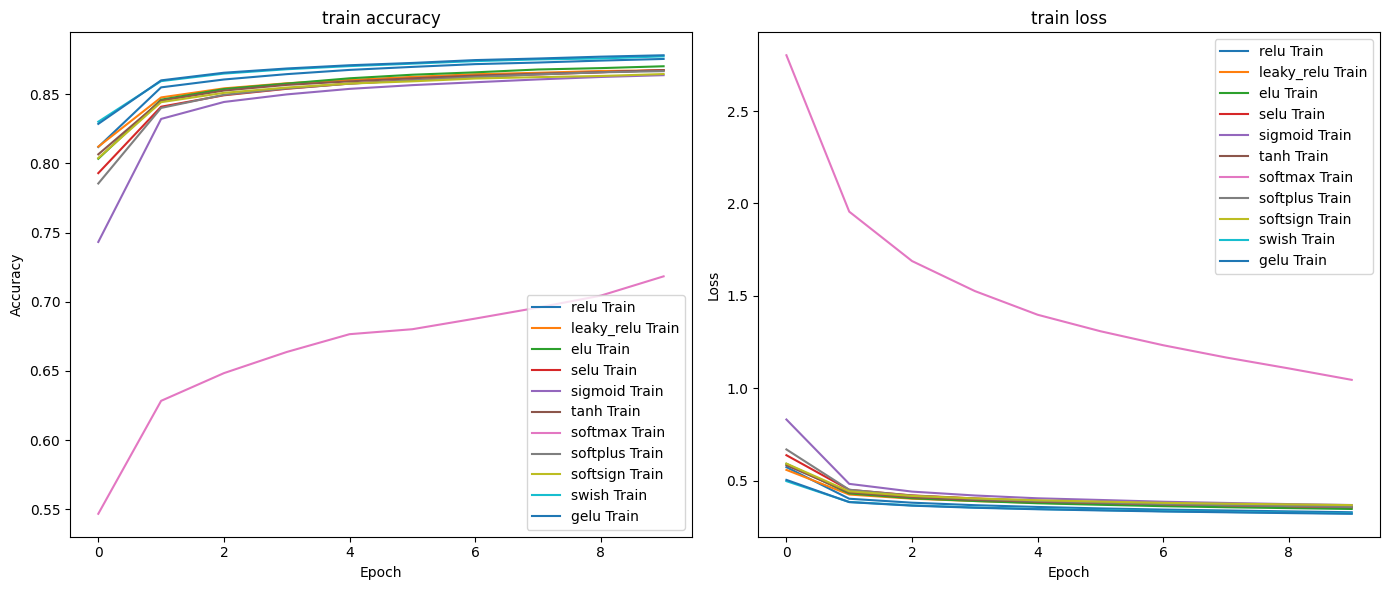

In [60]:
plt.figure(figsize=(14, 6))

for i, h in enumerate(history):
    plt.subplot(1, 2, 1)
    plt.plot(h.history['accuracy'], label=f'{activation_functions[i]} Train')
    plt.title('train accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(h.history['loss'], label=f'{activation_functions[i]} Train')
    plt.title('train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

plt.tight_layout()
plt.savefig(f"{result_path}/result_activation_{_time}.png")
plt.show()

In [77]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Activation Function", y="Loss", hue="Activation Function",
            data=results_df, palette="viridis", legend=False)
plt.title(f'{"Loss"} Comparison')
plt.ylabel("Loss")
plt.xlabel('Activation Function')
plt.ylim([0.8, 1])
plt.tight_layout()
plt.savefig(f'{result_path}/{"Loss".lower().replace(" ", "_")}_comparison_{_time}.png')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x="Activation Function", y="Accuracy", hue="Activation Function",
            data=results_df, palette="viridis", legend=False)
plt.title(f'{"Accuracy"} Comparison')
plt.ylabel("Accuracy")
plt.xlabel('Activation Function')
plt.ylim([0.8, 1])
plt.tight_layout()
plt.savefig(f'{result_path}/{"Accuracy".lower().replace(" ", "_")}_comparison_{_time}.png')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x="Activation Function", y="Training Time", hue="Activation Function",
            data=results_df, palette="viridis", legend=False)
plt.title(f'{"Training Time"} Comparison')
plt.ylabel("Training Time")
plt.xlabel('Activation Function')
plt.tight_layout()
plt.savefig(f'{result_path}/{"Training Time".lower().replace(" ", "_")}_comparison_{_time}.png')
plt.show()

ValueError: Could not interpret value `Activation Function` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

## 2.3. The number of Residual Blocks

In [62]:
history = []
training_time = []

In [63]:
callbacks_final = create_callbacks('final')

In [64]:
our_model_1res = ResModel(num_residual_units=1, activation='gelu')
our_model_2res = ResModel(num_residual_units=2, activation='gelu')
our_model_3res = ResModel(num_residual_units=3, activation='gelu')
our_model_4res = ResModel(num_residual_units=4, activation='gelu')

In [65]:
our_model_1res.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_2res.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_3res.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_4res.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [66]:
EPOCHS = 50
BATCH_SIZE = 500

In [67]:
start_time = time.time()
history.append(our_model_1res.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_final]))
end_time = time.time()
training_time.append(end_time-start_time)

start_time = time.time()
history.append(our_model_2res.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_final]))
end_time = time.time()
training_time.append(end_time-start_time)


start_time = time.time()
history.append(our_model_3res.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_final]))
end_time = time.time()
training_time.append(end_time-start_time)


start_time = time.time()
history.append(our_model_4res.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_final]))
end_time = time.time()
training_time.append(end_time-start_time)

Epoch 1/50


2024-05-28 21:58:34.046588: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_20/dropout_95/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1254/1257 [============================>.] - ETA: 0s - loss: 0.5590 - accuracy: 0.8164
Epoch 1: val_loss improved from inf to 0.37965, saving model to ./checkpoints/checkpoints_final/weights.1716901106.hdf5
1257/1257 [==============================] - 25s 18ms/step - loss: 0.5588 - accuracy: 0.8164 - val_loss: 0.3797 - val_accuracy: 0.8606 - lr: 0.0010
Epoch 2/50
   5/1257 [..............................] - ETA: 20s - loss: 0.4001 - accuracy: 0.8580

/home/suhohan/anaconda3/envs/ann/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1257/1257 [==============================] - ETA: 0s - loss: 0.4064 - accuracy: 0.8540
Epoch 2: val_loss improved from 0.37965 to 0.36030, saving model to ./checkpoints/checkpoints_final/weights.1716901106.hdf5
1257/1257 [==============================] - 22s 17ms/step - loss: 0.4064 - accuracy: 0.8540 - val_loss: 0.3603 - val_accuracy: 0.8670 - lr: 0.0010
Epoch 3/50
1257/1257 [==============================] - ETA: 0s - loss: 0.3824 - accuracy: 0.8602
Epoch 3: val_loss improved from 0.36030 to 0.35089, saving model to ./checkpoints/checkpoints_final/weights.1716901106.hdf5
1257/1257 [==============================] - 22s 17ms/step - loss: 0.3824 - accuracy: 0.8602 - val_loss: 0.3509 - val_accuracy: 0.8703 - lr: 0.0010
Epoch 4/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3692 - accuracy: 0.8644
Epoch 4: val_loss improved from 0.35089 to 0.34425, saving model to ./checkpoints/checkpoints_final/weights.1716901106.hdf5
1257/1257 [==============================] - 22s 

2024-05-28 22:17:03.163275: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_21/dropout_98/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1256/1257 [============================>.] - ETA: 0s - loss: 0.5356 - accuracy: 0.8216
Epoch 1: val_loss did not improve from 0.32346
1257/1257 [==============================] - 32s 23ms/step - loss: 0.5356 - accuracy: 0.8216 - val_loss: 0.3724 - val_accuracy: 0.8633 - lr: 0.0010
Epoch 2/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3916 - accuracy: 0.8576
Epoch 2: val_loss did not improve from 0.32346
1257/1257 [==============================] - 27s 22ms/step - loss: 0.3916 - accuracy: 0.8576 - val_loss: 0.3609 - val_accuracy: 0.8675 - lr: 0.0010
Epoch 3/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3707 - accuracy: 0.8635
Epoch 3: val_loss did not improve from 0.32346
1257/1257 [==============================] - 28s 22ms/step - loss: 0.3707 - accuracy: 0.8634 - val_loss: 0.3415 - val_accuracy: 0.8727 - lr: 0.0010
Epoch 4/50
1257/1257 [==============================] - ETA: 0s - loss: 0.3591 - accuracy: 0.8666
Epoch 4: val_loss did not improve 

2024-05-28 22:40:40.880038: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_22/dropout_102/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 0.5349 - accuracy: 0.8214
Epoch 1: val_loss did not improve from 0.31633
1257/1257 [==============================] - 41s 27ms/step - loss: 0.5349 - accuracy: 0.8214 - val_loss: 0.3734 - val_accuracy: 0.8613 - lr: 0.0010
Epoch 2/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.3891 - accuracy: 0.8581
Epoch 2: val_loss did not improve from 0.31633
1257/1257 [==============================] - 33s 26ms/step - loss: 0.3891 - accuracy: 0.8581 - val_loss: 0.3563 - val_accuracy: 0.8685 - lr: 0.0010
Epoch 3/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3681 - accuracy: 0.8640
Epoch 3: val_loss did not improve from 0.31633
1257/1257 [==============================] - 32s 26ms/step - loss: 0.3682 - accuracy: 0.8639 - val_loss: 0.3501 - val_accuracy: 0.8711 - lr: 0.0010
Epoch 4/50
1257/1257 [==============================] - ETA: 0s - loss: 0.3558 - accuracy: 0.8676
Epoch 4: val_loss did not improve 

2024-05-28 23:08:30.820150: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_23/dropout_107/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 0.5463 - accuracy: 0.8179
Epoch 1: val_loss did not improve from 0.31633
1257/1257 [==============================] - 43s 29ms/step - loss: 0.5463 - accuracy: 0.8179 - val_loss: 0.3851 - val_accuracy: 0.8583 - lr: 0.0010
Epoch 2/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3923 - accuracy: 0.8573
Epoch 2: val_loss did not improve from 0.31633
1257/1257 [==============================] - 37s 30ms/step - loss: 0.3923 - accuracy: 0.8573 - val_loss: 0.3581 - val_accuracy: 0.8668 - lr: 0.0010
Epoch 3/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3712 - accuracy: 0.8630
Epoch 3: val_loss did not improve from 0.31633
1257/1257 [==============================] - 37s 30ms/step - loss: 0.3713 - accuracy: 0.8630 - val_loss: 0.3493 - val_accuracy: 0.8713 - lr: 0.0010
Epoch 4/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3591 - accuracy: 0.8668
Epoch 4: val_loss did not improve 

In [68]:
loss_our1res, acc_our1res = our_model_1res.evaluate(x_test, y_test_int)
loss_our2res, acc_our2res = our_model_2res.evaluate(x_test, y_test_int)
loss_our3res, acc_our3res = our_model_3res.evaluate(x_test, y_test_int)
loss_our4res, acc_our4res = our_model_4res.evaluate(x_test, y_test_int)

3636/3636 [==============================] - 12s 3ms/step - loss: 0.3303 - accuracy: 0.8830


In [69]:
results = {
    "Model": ["Our Model(Residual, 1 units)", "Our Model(Residual, 2 units)", "Our Model(Residual, 3 units)", "Our Model(Residual, 4 units)"],
    "Loss": [loss_our1res, loss_our2res, loss_our3res, loss_our4res],
    "Accuracy": [acc_our1res, acc_our2res, acc_our3res, acc_our4res],
    "Training Time": training_time
}

In [70]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_blocks_{_time}.csv', index=False)

In [71]:
for i, h in zip(range(1, 5), history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}  # Ensure values are float
    save_history(history_dict, f'history_block_{i}.json')

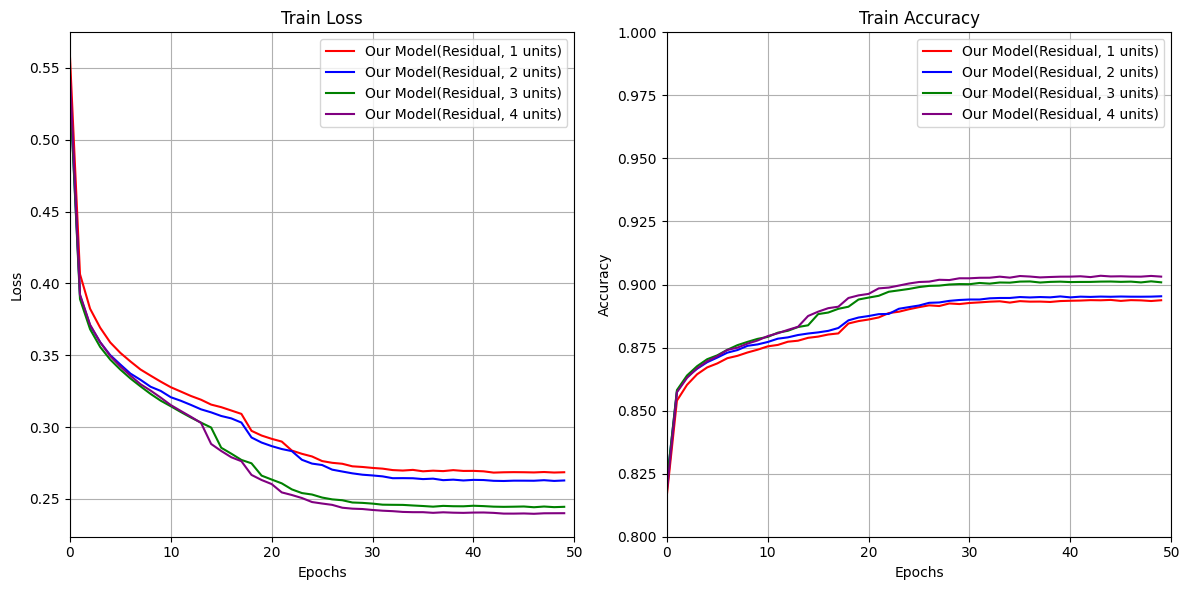

In [73]:
colors = ["red", "blue", "green", "purple", "gold", "orange"]

plt.figure(figsize=(12, 6))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0.8, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_blocks_{_time}.png")
plt.show()

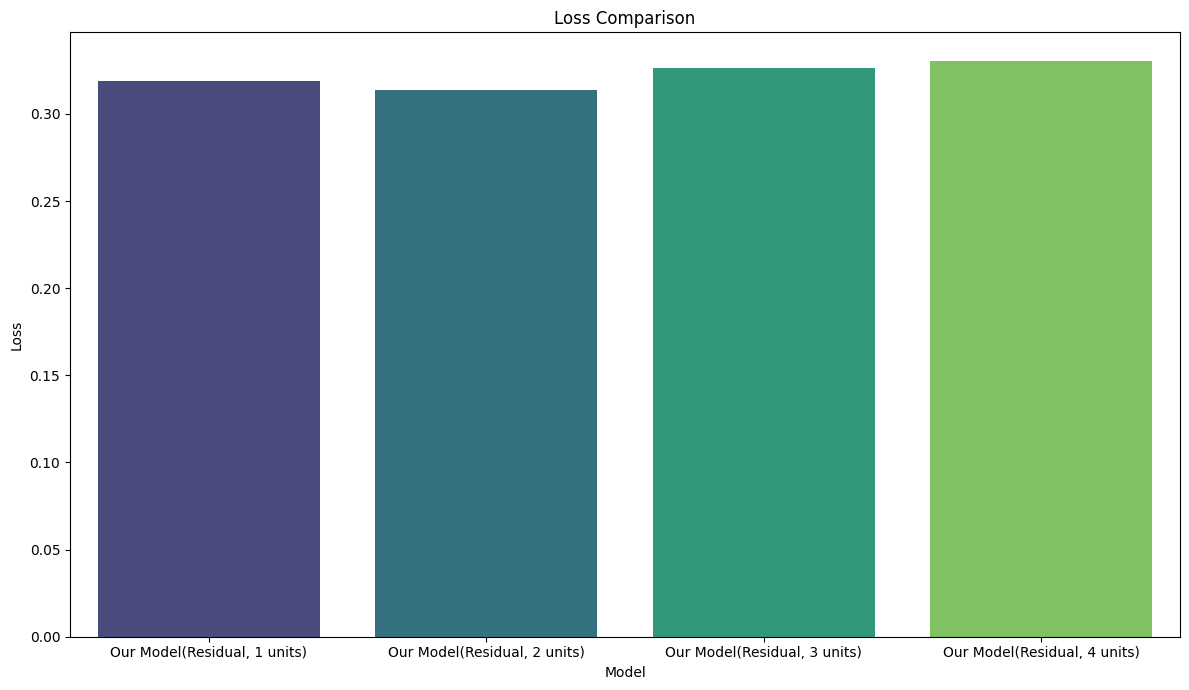

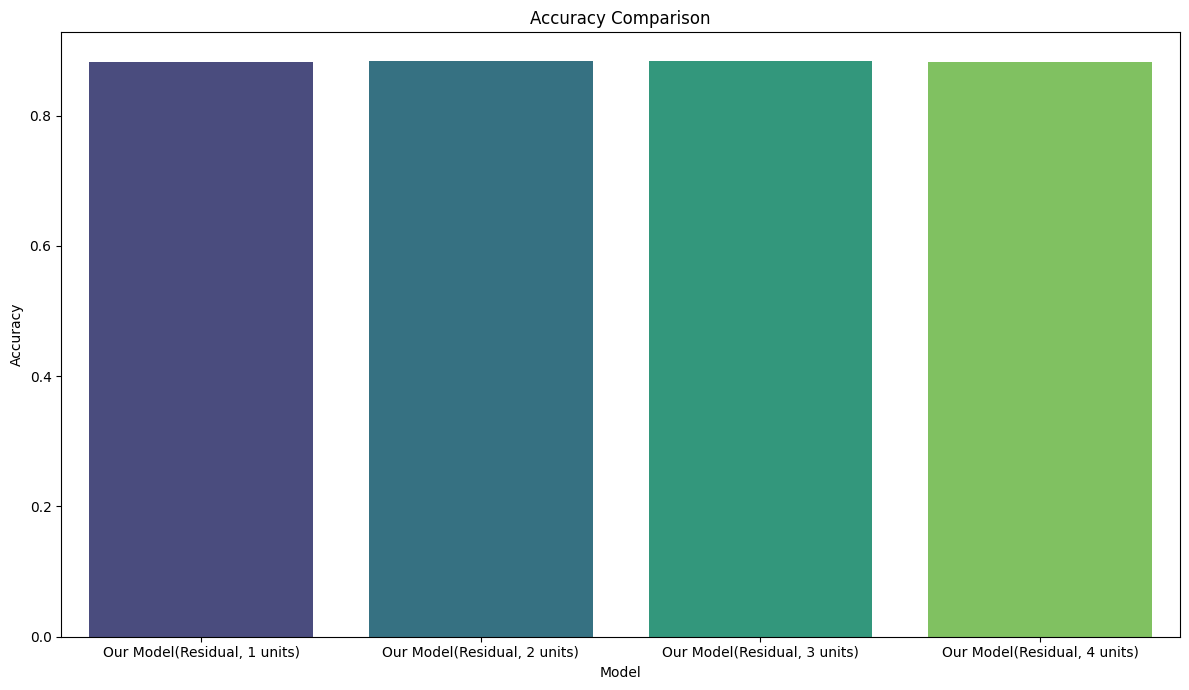

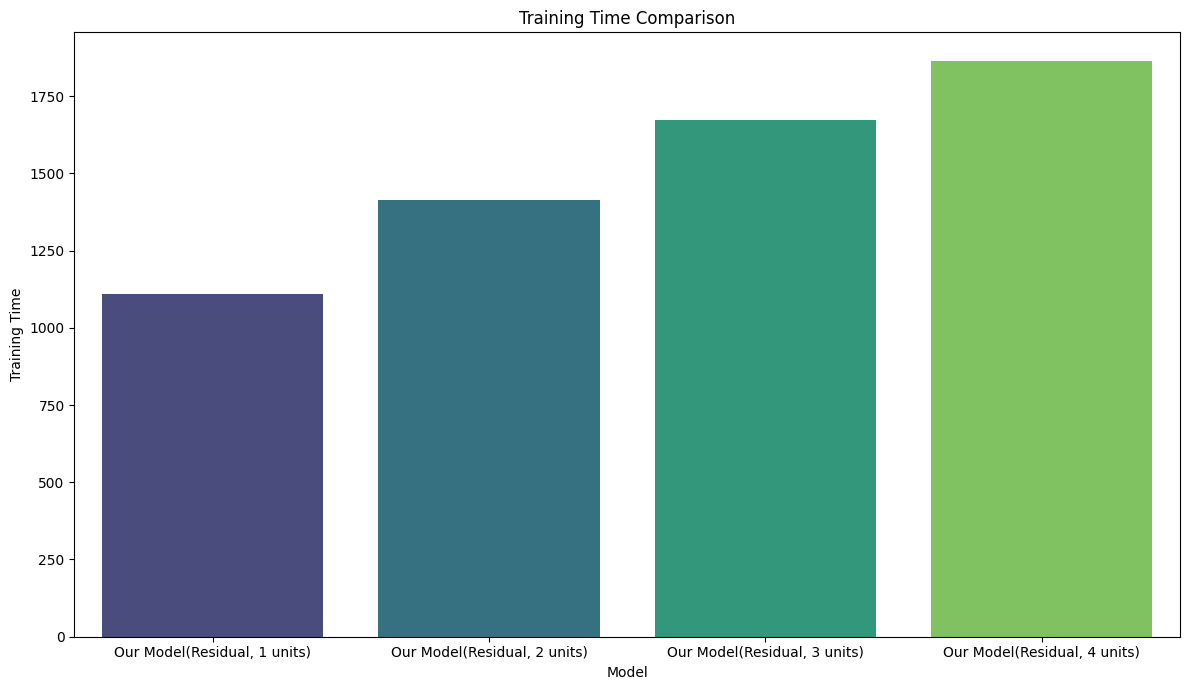

In [74]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(12, 7))
    sns.barplot(x="Model", y=metric, hue="Model", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_blocks_{_time}.png')
    plt.show()

## 2.4. Learning Rate

## 2.5. Loss function